# Treating Severe Acute Respiratory Syndrome (SRAG in portuguese) data

In [46]:
import pandas as pd
from matplotlib import pyplot as plt

## Reading data

In [2]:
EVOLUTION_TO_DEATH = 2

In [27]:
df = pd.read_csv('data/output/df_srag_raw.csv')

In [28]:
df.DT_SIN_PRI = pd.to_datetime(df.DT_SIN_PRI, infer_datetime_format=True)
df.DT_NOTIFIC = pd.to_datetime(df.DT_NOTIFIC, infer_datetime_format=True)
df.DT_DIGITA = pd.to_datetime(df.DT_DIGITA, infer_datetime_format=True)
df.DT_EVOLUCA = pd.to_datetime(df.DT_EVOLUCA, infer_datetime_format=True)

In [40]:
df.CO_MUN_RES = df.CO_MUN_RES.astype(pd.Int32Dtype()).astype('string')

## Describing data

In [6]:
df.DT_SIN_PRI.min()

Timestamp('2020-02-16 00:00:00')

In [7]:
df.DT_SIN_PRI.max()

Timestamp('2022-12-31 00:00:00')

In [11]:
df.DT_SIN_PRI.unique().shape[0]

1050

In [16]:
df[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False)].DT_EVOLUCA.min()

Timestamp('2020-03-12 00:00:00')

In [17]:
df[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False)].DT_EVOLUCA.max()

Timestamp('2023-03-30 00:00:00')

In [18]:
df[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False)].DT_EVOLUCA.unique().shape[0]

1097

In [20]:
len(df)

2166108

In [21]:
len(df[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False)])

669334

## Anomalies
We noted some anomalies in data, but, we prefer no treat this anomalies.

### Missing data

In [22]:
df.isnull().any()

DT_SIN_PRI    False
DT_NOTIFIC    False
DT_DIGITA     False
CO_MUN_RES     True
EVOLUCAO       True
DT_EVOLUCA     True
dtype: bool

In [38]:
df.CO_MUN_RES

0          355030
1          431490
2          355030
3          355030
4          355030
            ...  
2166103    261160
2166104    353760
2166105    412440
2166106    351620
2166107    430310
Name: CO_MUN_RES, Length: 2166108, dtype: Int32

### Seasonality

#### Symptoms

In [45]:
df_symptoms = df.groupby('DT_SIN_PRI').count().reset_index()

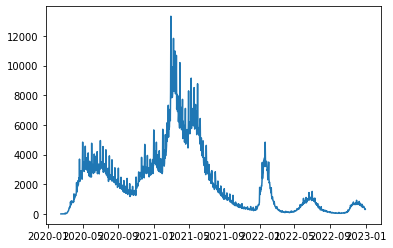

In [47]:
plt.plot(df_symptoms.DT_SIN_PRI, df_symptoms.DT_NOTIFIC)
plt.show()

In [48]:
df_symptoms['day_of_week'] = df_symptoms.DT_SIN_PRI.dt.dayofweek

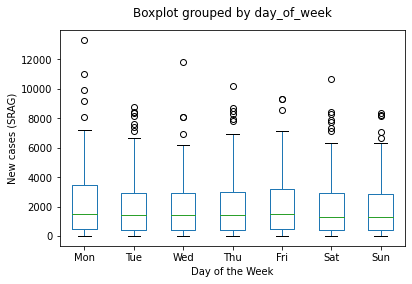

In [49]:
df_symptoms.boxplot(column='DT_NOTIFIC', by='day_of_week', grid=False)

# Customize plot
plt.title(None)
plt.xlabel('Day of the Week')
plt.ylabel('New cases (SRAG)')
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Show the plot
plt.show()

#### Deaths

In [51]:
df_deaths = df[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False)].groupby('DT_EVOLUCA').count().reset_index()

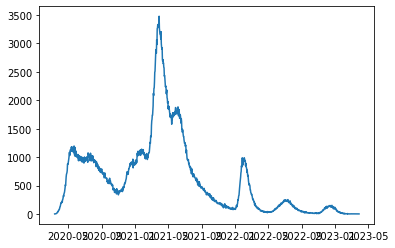

In [53]:
plt.plot(df_deaths.DT_EVOLUCA, df_deaths.DT_NOTIFIC)
plt.show()

In [54]:
df_deaths['day_of_week'] = df_deaths.DT_EVOLUCA.dt.dayofweek

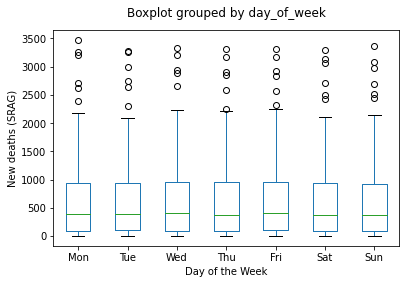

In [56]:
df_deaths.boxplot(column='DT_NOTIFIC', by='day_of_week', grid=False)

# Customize plot
plt.title(None)
plt.xlabel('Day of the Week')
plt.ylabel('New deaths (SRAG)')
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Show the plot
plt.show()

### Noise in data

In [66]:
df['DIF_DATA_SINTOMA_NOTIFICACAO'] = (df.DT_NOTIFIC - df.DT_SIN_PRI).dt.days
df.loc[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False),'DIF_DATA_SINTOMA_OBITO'] = (df[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False)].DT_EVOLUCA - df[(df.EVOLUCAO == EVOLUTION_TO_DEATH) & (df.DT_EVOLUCA.isna()==False)].DT_SIN_PRI).dt.days 

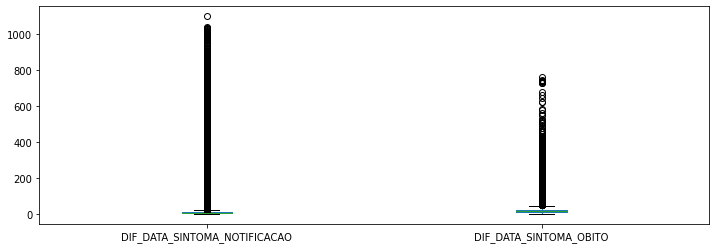

In [67]:
df.boxplot(column=['DIF_DATA_SINTOMA_NOTIFICACAO', 'DIF_DATA_SINTOMA_OBITO'], grid=False, figsize=(12,4))

# Show the plot
plt.show()

In [60]:
df.DIF_DATA_SINTOMA_NOTIFICACAO.describe().round(2)

count    2166108.00
mean          12.23
std           28.28
min            0.00
25%            4.00
50%            8.00
75%           12.00
max         1098.00
Name: DIF_DATA_SINTOMA_NOTIFICACAO, dtype: float64

In [191]:
len(df[df.DIF_DATA_SINTOMA_NOTIFICACAO>97.07])

25678

In [192]:
len(df)

2166108

In [193]:
len(df[df.DIF_DATA_SINTOMA_NOTIFICACAO>97.07])/len(df)*100

1.185444123746369

In [179]:
len(df[df.DIF_DATA_SINTOMA_OBITO > 76.78])

7100

In [180]:
len(df[df.DIF_DATA_SINTOMA_OBITO>76.78])/len(df)*100

0.3277768236856149

In [173]:
df.DIF_DATA_SINTOMA_OBITO.describe().round(2)

count    669334.00
mean         19.57
std          19.07
min           0.00
25%          10.00
50%          16.00
75%          25.00
max         759.00
Name: DIF_DATA_SINTOMA_OBITO, dtype: float64

## Preparing national time series

In [199]:
days = (df.DT_SIN_PRI.max() - df.DT_SIN_PRI.min()).days + 1

date_range = pd.date_range(start=df.DT_SIN_PRI.min(), end=df.DT_SIN_PRI.max(), periods=days)

# Create the DataFrame
df_ts_national = pd.DataFrame({'DATA': date_range})

In [200]:
df_ts_national 

,DATA
0,2020-02-16
1,2020-02-17
2,2020-02-18
3,2020-02-19
4,2020-02-20
...,...
1045,2022-12-27
1046,2022-12-28
1047,2022-12-29
1048,2022-12-30


In [198]:
df_symptoms = df_symptoms[['DT_SIN_PRI', 'DT_NOTIFIC']].rename(columns={'DT_SIN_PRI': 'DATA', 'DT_NOTIFIC': 'NOVOS_CASOS'})
df_symptoms

,DATA,NOVOS_CASOS
0,2020-02-16,5
1,2020-02-17,10
2,2020-02-18,8
3,2020-02-19,5
4,2020-02-20,7
...,...,...
1045,2022-12-27,462
1046,2022-12-28,409
1047,2022-12-29,343
1048,2022-12-30,365


In [201]:
df_ts_national = df_ts_national.merge(df_symptoms, how='left', on='DATA')

In [203]:
df_deaths = df_deaths[['DT_EVOLUCA', 'DT_NOTIFIC']].rename(columns={'DT_EVOLUCA': 'DATA', 'DT_NOTIFIC': 'NOVOS_OBITOS'})
df_deaths

,DATA,NOVOS_OBITOS
0,2020-03-12,1
1,2020-03-15,2
2,2020-03-16,3
3,2020-03-17,4
4,2020-03-18,9
...,...,...
1092,2023-03-15,2
1093,2023-03-16,1
1094,2023-03-19,1
1095,2023-03-23,1


In [204]:
df_ts_national = df_ts_national.merge(df_deaths, how='left', on='DATA')

In [206]:
df_ts_national = df_ts_national.fillna(0)
df_ts_national

,DATA,NOVOS_CASOS,NOVOS_OBITOS
0,2020-02-16,5,0.0
1,2020-02-17,10,0.0
2,2020-02-18,8,0.0
3,2020-02-19,5,0.0
4,2020-02-20,7,0.0
...,...,...,...
1045,2022-12-27,462,125.0
1046,2022-12-28,409,114.0
1047,2022-12-29,343,110.0
1048,2022-12-30,365,86.0


## Saving data

In [207]:
df_ts_national.to_csv('data/output/df_ts_srag_national.csv', index=False)

In [209]:
df_ts_national.NOVOS_CASOS.sum()

2166108

In [210]:
df_ts_national.NOVOS_OBITOS.sum()

667918.0